In [129]:
#!/usr/bin/env python3

from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.datasets import dump_svmlight_file
from sklearn import metrics
import numpy as np
import logging
import codecs
import re
import os
from nltk.corpus import sentiwordnet as swn


def parse_dataset(fp):
    '''
    Loads the dataset .txt file with label-tweet on each line and parses the dataset.
    :param fp: filepath of dataset
    :return:
        corpus: list of tweet strings of each tweet.
        y: list of labels
    '''
    y = []
    corpus = []
    with open(fp, 'rt') as data_in:
        for line in data_in:
            if not line.lower().startswith("tweet index"):  # discard first line if it contains metadata
                line = line.rstrip()  # remove trailing whitespace
                label = int(line.split("\t")[1])
                tweet = line.split("\t")[2]
                y.append(label)
                corpus.append(tweet)

    return corpus, y


def featurize(corpus):
    '''
    Tokenizes and creates TF-IDF BoW vectors.
    :param corpus: A list of strings each string representing document.
    :return: X: A sparse csr matrix of TFIDF-weigted ngram counts.
    '''

    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True).tokenize
    vectorizer = TfidfVectorizer(strip_accents="unicode", analyzer="word", tokenizer=tokenizer, stop_words="english")
    X = vectorizer.fit_transform(corpus)
    # print(vectorizer.get_feature_names()) # to manually check if the tokens are reasonable
    return X


In [130]:
# Dataset: SemEval2018-T4-train-taskA.txt or SemEval2018-T4-train-taskB.txt
DATASET_FP1 = "./SemEval2018-Task3/datasets/train/SemEval2018-T4-train-taskA.txt"
TASK1 = "A"  # Define, A or B
DATASET_FP2 = "./SemEval2018-Task3/datasets/train/SemEval2018-T4-train-taskB.txt"
TASK2 = "B"  # Define, A or B

FNAME = './predictions-task' + TASK1 + '.txt'
PREDICTIONSFILE = open(FNAME, "w")

In [131]:
corpus, inp_y1 = parse_dataset(DATASET_FP1)
corpus_copy, inp_y2 = parse_dataset(DATASET_FP2)
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True).tokenize

In [132]:
inp_X = []

for curr_sentence in corpus:
    curr_sentence = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', curr_sentence)
    curr_sentence = re.sub(r'@[a-zA-Z0-9_]+', ' ', curr_sentence)
    sentence_tokenized = tokenizer(curr_sentence)
    sent_list = []
    for curr_word in sentence_tokenized:
        if curr_word.startswith('#'):
            curr_word = curr_word[1:]
        curr_senti_synsets = swn.senti_synsets(curr_word)
        if len(curr_senti_synsets) > 0:
            c_pos = curr_senti_synsets[0].pos_score()
            c_neg = curr_senti_synsets[0].neg_score()
            c_obj = curr_senti_synsets[0].obj_score()
            # c_subj = max(1.0 - c_obj, 0.01)
            curr_sent = (c_pos - c_neg)
            if curr_sent != 0:
                sent_list.append(curr_sent)
    if len(sent_list) > MAX_LEN:
        for i in range(MAX_LEN,len(sent_list)):
            sent_list[MAX_LEN-1]+=sent_list[i]
        sent_list = sent_list[:MAX_LEN]
    for i in range(MAX_LEN - len(sent_list)):
        sent_list.append(0.0)
    inp_X.append(sent_list)

In [145]:
#############################################


#preprocess data files that contain word_embedding features.
#May need to change path based on where data is
directory = "./SemEval2018-Task3/datasets/word_embeddings"
#350 best for 25d, 550 best for 50d
MAX_LENGTH = 350
data_x = []

print("test")
#go through the feature files. Each file has 25 features
files = os.listdir(directory)
#os.chdir(directory)
for filename in files:
    example = []
    name = filename.split(".")
    file_num = int(name[0])
    sent_scores = inp_X[file_num-1]
    with open(directory+"/"+filename) as f:
        for line in f:
            tmp = line.split(" ")
            tmp = tmp[:len(tmp)-1]
            tmp = map(float, tmp)
            example = example + tmp
    example = np.array(example)
    #print(example.shape)
    if len(example)>MAX_LENGTH:
        example = example[:MAX_LENGTH]
    if len(example)<MAX_LENGTH:
        example = np.pad(example, (0,MAX_LENGTH-len(example)), 'constant')
    example = np.append(example, sent_scores)
    #example = np.append(example, label)
    data_x.append(example)
data_x = np.array(data_x)
print("data_x dims")
print(data_x.shape)


test
data_x dims
(3834, 365)


In [85]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils

In [120]:
from __future__ import print_function
import keras
from keras import backend as K
from keras.engine.topology import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import matplotlib.pyplot as plt

In [87]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torch.utils.data
import gc
import resource
print(torch.__version__)

0.4.1


In [90]:
split=3000
X_train = data_x[:split]
X_test = data_x[split:]
print("X_train dims")
print(X_train.shape)
print("X_test dims")
print(X_test.shape)

y_train = inp_y1[:split]
y_test = inp_y1[split:]

yf_train = inp_y2[:split]
yf_test = inp_y2[split:]

nb_classes = max(inp_y1)+1
num_classes = max(inp_y2)+1

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# convert class vectors to binary class matrices
Yf_train = np_utils.to_categorical(yf_train, num_classes)
Yf_test = np_utils.to_categorical(yf_test, num_classes)

X_train dims
(3000, 365)
X_test dims
(834, 365)


In [92]:
tensor_x_train = torch.Tensor(X_train)
tensor_x_test = torch.Tensor(X_test)
tensor_yc_train = torch.LongTensor(y_train)
tensor_yf_train = torch.LongTensor(yf_train)
print(tensor_x_train.shape)
print(tensor_x_test.shape)
print(tensor_yc_train.shape)
print(tensor_yf_train.shape)

torch.Size([3000, 365])
torch.Size([834, 365])
torch.Size([3000])
torch.Size([3000])


In [94]:
tensor_yc_test = torch.LongTensor(y_test)
tensor_yf_test = torch.LongTensor(yf_test)
print(tensor_x_test.shape)
print(tensor_yc_test.shape)
print(tensor_yf_test.shape)

torch.Size([834, 365])
torch.Size([834])
torch.Size([834])


In [168]:
batch_size = 256
epochs = 500
learning_rate = 3e-4
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_yc_train,tensor_yf_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_test,tensor_yc_test,tensor_yf_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [99]:
print(len(train_loader))
print(len(val_loader))

12
4


In [169]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv1 = nn.Conv1d(1, 2, 6) #20*361
        #self.pool = nn.MaxPool1d(2, 2) #20*180
        #self.conv2 = nn.Conv1d(2, 5, 1) #5*5*16
        self.fc1 = nn.Linear(365, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 2)
        self.fc4 = nn.Linear(20, 4)

    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x)) #16 * 5 * 5
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        z = self.fc4(x)
        return y,z
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

for i in net.parameters():
    print(i.shape)
    
summary(net, (1,365))

torch.Size([100, 365])
torch.Size([100])
torch.Size([20, 100])
torch.Size([20])
torch.Size([2, 20])
torch.Size([2])
torch.Size([4, 20])
torch.Size([4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          36,600
            Linear-2                   [-1, 20]           2,020
            Linear-3                    [-1, 2]              42
            Linear-4                    [-1, 4]              84
Total params: 38,746
Trainable params: 38,746
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [155]:
import math
import torch
from torch.optim import Optimizer


class Adam(Optimizer):
    """Implements Adam algorithm.

    It has been proposed in `Adam: A Method for Stochastic Optimization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
    
    def step(self, alpha, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = alpha * group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

In [170]:
import torch
torch.manual_seed(1337)

# Loss and Optimizer

#Can also try nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer1 = Adam([i for i in net.parameters() if i.shape != torch.Size([4]) and i.shape != torch.Size([4, 100])], lr=learning_rate, weight_decay=0.03)
optimizer2 = Adam([i for i in net.parameters() if i.shape != torch.Size([2]) and i.shape != torch.Size([2, 100])], lr=learning_rate, weight_decay=0.03)

train_acc = []
val_acc = []
trainc_acc = []
valc_acc = []
trainf_acc = []
valf_acc = []

loss_history = []
lossc_history = []
lossf_history = []

for epoch in range(epochs):
    for i, (images, labelc, labelf) in enumerate(train_loader):
        net.train() # Change model to 'train' mode.
    #     for i in range(cnn_training_data_X.shape[0]):
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
    #     print images.shape
        labelc = Variable(labelc, requires_grad=False)
        labelf = Variable(labelf, volatile=True)
        #labels = [labelc, labelf]

        # Forward + Backward + Optimize
        net.zero_grad()
        #outputs = net(images)
        
        
        outc, outf = net(images)
        lossc = criterion(outc, labelc)
        lossf = criterion(outf, labelf)
        loss = lossc + lossf
        
        alpha_ = lossf/(lossc+lossf)
        
        #loss = criterion(outputs, labelc)
        #loss.backward()
        
        loss_history.append(loss.data)
        lossc_history.append(lossc.data)
        lossf_history.append(lossf.data)
        
        loss.backward()
        
        
        optimizer1.step(alpha=alpha_.data)
        optimizer2.step(alpha=(1-alpha_.data))
        
        #for f in net.parameters():
            #if f.shape != torch.Size([100]) and f.shape != torch.Size([100, 200]):
            #f.data.sub_(f.grad.data * learning_rate)
        if (i+1) % 20 == 0:
            print(alpha_.data)
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, %.4f, %.4f' 
                   %(epoch+1, epochs, i+1, len(X_train.shape)//batch_size, lossc.data, lossf.data,loss.data))
    print('[%d/%d] Loss: %.3f' % (epoch+1, epochs, np.mean(loss_history)))
    
    
    correctc = 0
    correctf = 0
    total = 0
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    with torch.no_grad():
        for data in train_loader:
            images, labelc, labelf = data
            outputc, outputf = net(images)
            _, predictedc = torch.max(outputc.data, 1)
            _, predictedf = torch.max(outputf.data, 1)
            total += labelc.size(0)
            correctc += (predictedc == labelc).sum().item()
            correctf += (predictedf == labelf).sum().item()
    print(total)
    trainc_acc_val = (100 * correctc / total)
    trainf_acc_val = (100 * correctf / total)
    train_acc_val = (trainc_acc_val + trainf_acc_val)/2.0
    trainc_acc.append(trainc_acc_val)
    trainf_acc.append(trainf_acc_val)
    train_acc.append(train_acc_val)
    print('Accuracy of the network on the 3000 train dataset coarse: %d %%' % (trainc_acc_val))
    print('Accuracy of the network on the 3000 train dataset fine: %d %%' % (trainf_acc_val))
    print('Average Accuracy of the network on the 3000 dataset images: %d %%' % (train_acc_val))
          
    correctc = 0
    correctf = 0
    total = 0
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    with torch.no_grad():
        for data in val_loader:
            images, labelc, labelf = data
            outputc, outputf = net(images)
            _, predictedc = torch.max(outputc.data, 1)
            _, predictedf = torch.max(outputf.data, 1)
            total += labelc.size(0)
            correctc += (predictedc == labelc).sum().item()
            correctf += (predictedf == labelf).sum().item()

    valc_acc_val = (100 * correctc / total)
    valf_acc_val = (100 * correctf / total)
    val_acc_val = (valc_acc_val + valf_acc_val)/2.0
    valc_acc.append(valc_acc_val)
    valf_acc.append(valf_acc_val)
    val_acc.append(val_acc_val)
    print('Accuracy of the network on the 834 test dataset coarse: %d %%' % (valc_acc_val))
    print('Accuracy of the network on the 834 test dataset fine: %d %%' % (valf_acc_val))
    print('Average Accuracy of the network on the 834 test dataset: %d %%' % (val_acc_val))

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:29: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[1/500] Loss: 2.082
3000
Accuracy of the network on the 3000 train dataset coarse: 50 %
Accuracy of the network on the 3000 train dataset fine: 29 %
Average Accuracy of the network on the 3000 dataset images: 39 %
Accuracy of the network on the 834 test dataset coarse: 46 %
Accuracy of the network on the 834 test dataset fine: 27 %
Average Accuracy of the network on the 834 test dataset: 36 %
[2/500] Loss: 2.055
3000
Accuracy of the network on the 3000 train dataset coarse: 52 %
Accuracy of the network on the 3000 train dataset fine: 46 %
Average Accuracy of the network on the 3000 dataset images: 49 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 46 %
Average Accuracy of the network on the 834 test dataset: 47 %
[3/500] Loss: 2.028
3000
Accuracy of the network on the 3000 train dataset coarse: 51 %
Accuracy of the network on the 3000 train dataset fine: 49 %
Average Accuracy of the network on the 3000 dataset images:

[23/500] Loss: 1.823
3000
Accuracy of the network on the 3000 train dataset coarse: 58 %
Accuracy of the network on the 3000 train dataset fine: 49 %
Average Accuracy of the network on the 3000 dataset images: 53 %
Accuracy of the network on the 834 test dataset coarse: 47 %
Accuracy of the network on the 834 test dataset fine: 51 %
Average Accuracy of the network on the 834 test dataset: 49 %
[24/500] Loss: 1.821
3000
Accuracy of the network on the 3000 train dataset coarse: 58 %
Accuracy of the network on the 3000 train dataset fine: 49 %
Average Accuracy of the network on the 3000 dataset images: 53 %
Accuracy of the network on the 834 test dataset coarse: 48 %
Accuracy of the network on the 834 test dataset fine: 51 %
Average Accuracy of the network on the 834 test dataset: 49 %
[25/500] Loss: 1.818
3000
Accuracy of the network on the 3000 train dataset coarse: 58 %
Accuracy of the network on the 3000 train dataset fine: 49 %
Average Accuracy of the network on the 3000 dataset imag

[45/500] Loss: 1.782
3000
Accuracy of the network on the 3000 train dataset coarse: 60 %
Accuracy of the network on the 3000 train dataset fine: 53 %
Average Accuracy of the network on the 3000 dataset images: 56 %
Accuracy of the network on the 834 test dataset coarse: 48 %
Accuracy of the network on the 834 test dataset fine: 50 %
Average Accuracy of the network on the 834 test dataset: 49 %
[46/500] Loss: 1.780
3000
Accuracy of the network on the 3000 train dataset coarse: 61 %
Accuracy of the network on the 3000 train dataset fine: 54 %
Average Accuracy of the network on the 3000 dataset images: 57 %
Accuracy of the network on the 834 test dataset coarse: 48 %
Accuracy of the network on the 834 test dataset fine: 48 %
Average Accuracy of the network on the 834 test dataset: 48 %
[47/500] Loss: 1.779
3000
Accuracy of the network on the 3000 train dataset coarse: 61 %
Accuracy of the network on the 3000 train dataset fine: 54 %
Average Accuracy of the network on the 3000 dataset imag

[66/500] Loss: 1.752
3000
Accuracy of the network on the 3000 train dataset coarse: 64 %
Accuracy of the network on the 3000 train dataset fine: 57 %
Average Accuracy of the network on the 3000 dataset images: 60 %
Accuracy of the network on the 834 test dataset coarse: 48 %
Accuracy of the network on the 834 test dataset fine: 49 %
Average Accuracy of the network on the 834 test dataset: 48 %
[67/500] Loss: 1.751
3000
Accuracy of the network on the 3000 train dataset coarse: 64 %
Accuracy of the network on the 3000 train dataset fine: 56 %
Average Accuracy of the network on the 3000 dataset images: 60 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 49 %
Average Accuracy of the network on the 834 test dataset: 49 %
[68/500] Loss: 1.749
3000
Accuracy of the network on the 3000 train dataset coarse: 65 %
Accuracy of the network on the 3000 train dataset fine: 58 %
Average Accuracy of the network on the 3000 dataset imag

[88/500] Loss: 1.714
3000
Accuracy of the network on the 3000 train dataset coarse: 69 %
Accuracy of the network on the 3000 train dataset fine: 60 %
Average Accuracy of the network on the 3000 dataset images: 64 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 49 %
Average Accuracy of the network on the 834 test dataset: 49 %
[89/500] Loss: 1.712
3000
Accuracy of the network on the 3000 train dataset coarse: 71 %
Accuracy of the network on the 3000 train dataset fine: 62 %
Average Accuracy of the network on the 3000 dataset images: 66 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 47 %
Average Accuracy of the network on the 834 test dataset: 48 %
[90/500] Loss: 1.710
3000
Accuracy of the network on the 3000 train dataset coarse: 72 %
Accuracy of the network on the 3000 train dataset fine: 64 %
Average Accuracy of the network on the 3000 dataset imag

[110/500] Loss: 1.654
3000
Accuracy of the network on the 3000 train dataset coarse: 82 %
Accuracy of the network on the 3000 train dataset fine: 71 %
Average Accuracy of the network on the 3000 dataset images: 76 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[111/500] Loss: 1.651
3000
Accuracy of the network on the 3000 train dataset coarse: 83 %
Accuracy of the network on the 3000 train dataset fine: 72 %
Average Accuracy of the network on the 3000 dataset images: 77 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[112/500] Loss: 1.648
3000
Accuracy of the network on the 3000 train dataset coarse: 83 %
Accuracy of the network on the 3000 train dataset fine: 73 %
Average Accuracy of the network on the 3000 dataset i

[132/500] Loss: 1.575
3000
Accuracy of the network on the 3000 train dataset coarse: 89 %
Accuracy of the network on the 3000 train dataset fine: 76 %
Average Accuracy of the network on the 3000 dataset images: 82 %
Accuracy of the network on the 834 test dataset coarse: 52 %
Accuracy of the network on the 834 test dataset fine: 45 %
Average Accuracy of the network on the 834 test dataset: 48 %
[133/500] Loss: 1.572
3000
Accuracy of the network on the 3000 train dataset coarse: 90 %
Accuracy of the network on the 3000 train dataset fine: 77 %
Average Accuracy of the network on the 3000 dataset images: 83 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 45 %
Average Accuracy of the network on the 834 test dataset: 47 %
[134/500] Loss: 1.568
3000
Accuracy of the network on the 3000 train dataset coarse: 90 %
Accuracy of the network on the 3000 train dataset fine: 77 %
Average Accuracy of the network on the 3000 dataset i

[154/500] Loss: 1.493
3000
Accuracy of the network on the 3000 train dataset coarse: 93 %
Accuracy of the network on the 3000 train dataset fine: 80 %
Average Accuracy of the network on the 3000 dataset images: 86 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 45 %
Average Accuracy of the network on the 834 test dataset: 48 %
[155/500] Loss: 1.489
3000
Accuracy of the network on the 3000 train dataset coarse: 93 %
Accuracy of the network on the 3000 train dataset fine: 79 %
Average Accuracy of the network on the 3000 dataset images: 86 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 45 %
Average Accuracy of the network on the 834 test dataset: 48 %
[156/500] Loss: 1.485
3000
Accuracy of the network on the 3000 train dataset coarse: 94 %
Accuracy of the network on the 3000 train dataset fine: 80 %
Average Accuracy of the network on the 3000 dataset i

[175/500] Loss: 1.419
3000
Accuracy of the network on the 3000 train dataset coarse: 95 %
Accuracy of the network on the 3000 train dataset fine: 81 %
Average Accuracy of the network on the 3000 dataset images: 88 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[176/500] Loss: 1.416
3000
Accuracy of the network on the 3000 train dataset coarse: 95 %
Accuracy of the network on the 3000 train dataset fine: 81 %
Average Accuracy of the network on the 3000 dataset images: 88 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[177/500] Loss: 1.412
3000
Accuracy of the network on the 3000 train dataset coarse: 95 %
Accuracy of the network on the 3000 train dataset fine: 80 %
Average Accuracy of the network on the 3000 dataset i

[196/500] Loss: 1.354
3000
Accuracy of the network on the 3000 train dataset coarse: 96 %
Accuracy of the network on the 3000 train dataset fine: 82 %
Average Accuracy of the network on the 3000 dataset images: 89 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 45 %
Average Accuracy of the network on the 834 test dataset: 47 %
[197/500] Loss: 1.351
3000
Accuracy of the network on the 3000 train dataset coarse: 96 %
Accuracy of the network on the 3000 train dataset fine: 82 %
Average Accuracy of the network on the 3000 dataset images: 89 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[198/500] Loss: 1.348
3000
Accuracy of the network on the 3000 train dataset coarse: 96 %
Accuracy of the network on the 3000 train dataset fine: 82 %
Average Accuracy of the network on the 3000 dataset i

[218/500] Loss: 1.294
3000
Accuracy of the network on the 3000 train dataset coarse: 96 %
Accuracy of the network on the 3000 train dataset fine: 82 %
Average Accuracy of the network on the 3000 dataset images: 89 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[219/500] Loss: 1.291
3000
Accuracy of the network on the 3000 train dataset coarse: 96 %
Accuracy of the network on the 3000 train dataset fine: 83 %
Average Accuracy of the network on the 3000 dataset images: 89 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[220/500] Loss: 1.289
3000
Accuracy of the network on the 3000 train dataset coarse: 96 %
Accuracy of the network on the 3000 train dataset fine: 83 %
Average Accuracy of the network on the 3000 dataset i

[240/500] Loss: 1.242
3000
Accuracy of the network on the 3000 train dataset coarse: 96 %
Accuracy of the network on the 3000 train dataset fine: 83 %
Average Accuracy of the network on the 3000 dataset images: 89 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[241/500] Loss: 1.240
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 83 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 45 %
Average Accuracy of the network on the 834 test dataset: 47 %
[242/500] Loss: 1.238
3000
Accuracy of the network on the 3000 train dataset coarse: 96 %
Accuracy of the network on the 3000 train dataset fine: 83 %
Average Accuracy of the network on the 3000 dataset i

[261/500] Loss: 1.199
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 83 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[262/500] Loss: 1.197
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 83 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[263/500] Loss: 1.195
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 83 %
Average Accuracy of the network on the 3000 dataset i

[282/500] Loss: 1.161
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[283/500] Loss: 1.160
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 47 %
[284/500] Loss: 1.158
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset i

Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[304/500] Loss: 1.127
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 47 %
[305/500] Loss: 1.125
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[306/500] Loss: 1.124


Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[326/500] Loss: 1.096
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 47 %
[327/500] Loss: 1.094
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of

[346/500] Loss: 1.071
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[347/500] Loss: 1.070
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[348/500] Loss: 1.068
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset i

[368/500] Loss: 1.046
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[369/500] Loss: 1.045
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 52 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 47 %
[370/500] Loss: 1.044
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset i

Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 47 %
[390/500] Loss: 1.023
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 47 %
[391/500] Loss: 1.022
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[392/500] Loss: 1.021
3000
Accuracy of the network on the 3000 train dataset coarse

[411/500] Loss: 1.004
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 47 %
[412/500] Loss: 1.003
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[413/500] Loss: 1.002
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset i

[432/500] Loss: 0.986
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[433/500] Loss: 0.985
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[434/500] Loss: 0.984
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset i

[453/500] Loss: 0.970
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[454/500] Loss: 0.969
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[455/500] Loss: 0.968
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset i

3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[475/500] Loss: 0.954
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[476/500] Loss: 0.954
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy o

[495/500] Loss: 0.941
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[496/500] Loss: 0.940
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[497/500] Loss: 0.940
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset i

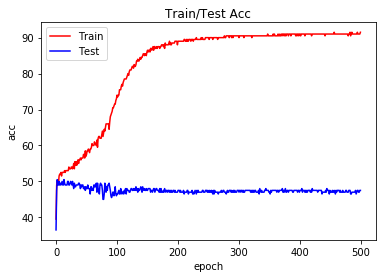

In [171]:
#plot train/val accuracies
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
line1 = plt.plot(train_acc, color='red')
line2 = plt.plot(val_acc, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlp1.png')   # save the figure to file
plt.show()
plt.close()

In [173]:
import torch
torch.manual_seed(1337)

# Loss and Optimizer

#Can also try nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.03)

train_acc = []
val_acc = []
trainc_acc = []
valc_acc = []
trainf_acc = []
valf_acc = []

loss_history = []
lossc_history = []
lossf_history = []

for epoch in range(epochs):
    for i, (images, labelc, labelf) in enumerate(train_loader):
        net.train() # Change model to 'train' mode.
    #     for i in range(cnn_training_data_X.shape[0]):
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
    #     print images.shape
        labelc = Variable(labelc, requires_grad=False)
        labelf = Variable(labelf, volatile=True)
        #labels = [labelc, labelf]

        # Forward + Backward + Optimize
        net.zero_grad()
        #outputs = net(images)
        
        
        outc, outf = net(images)
        lossc = criterion(outc, labelc)
        lossf = criterion(outf, labelf)
        loss = lossc + lossf
        
        
        #loss = criterion(outputs, labelc)
        #loss.backward()
        
        loss_history.append(loss.data)
        lossc_history.append(lossc.data)
        lossf_history.append(lossf.data)
        
        loss.backward()
        
        
        optimizer.step()
        
        #for f in net.parameters():
            #if f.shape != torch.Size([100]) and f.shape != torch.Size([100, 200]):
            #f.data.sub_(f.grad.data * learning_rate)
        if (i+1) % 20 == 0:
            print(alpha_.data)
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, %.4f, %.4f' 
                   %(epoch+1, epochs, i+1, len(X_train.shape)//batch_size, lossc.data, lossf.data,loss.data))
    print('[%d/%d] Loss: %.3f' % (epoch+1, epochs, np.mean(loss_history)))
    
    
    correctc = 0
    correctf = 0
    total = 0
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    with torch.no_grad():
        for data in train_loader:
            images, labelc, labelf = data
            outputc, outputf = net(images)
            _, predictedc = torch.max(outputc.data, 1)
            _, predictedf = torch.max(outputf.data, 1)
            total += labelc.size(0)
            correctc += (predictedc == labelc).sum().item()
            correctf += (predictedf == labelf).sum().item()
    print(total)
    trainc_acc_val = (100 * correctc / total)
    trainf_acc_val = (100 * correctf / total)
    train_acc_val = (trainc_acc_val + trainf_acc_val)/2.0
    trainc_acc.append(trainc_acc_val)
    trainf_acc.append(trainf_acc_val)
    train_acc.append(train_acc_val)
    print('Accuracy of the network on the 3000 train dataset coarse: %d %%' % (trainc_acc_val))
    print('Accuracy of the network on the 3000 train dataset fine: %d %%' % (trainf_acc_val))
    print('Average Accuracy of the network on the 3000 dataset images: %d %%' % (train_acc_val))
          
    correctc = 0
    correctf = 0
    total = 0
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    with torch.no_grad():
        for data in val_loader:
            images, labelc, labelf = data
            outputc, outputf = net(images)
            _, predictedc = torch.max(outputc.data, 1)
            _, predictedf = torch.max(outputf.data, 1)
            total += labelc.size(0)
            correctc += (predictedc == labelc).sum().item()
            correctf += (predictedf == labelf).sum().item()

    valc_acc_val = (100 * correctc / total)
    valf_acc_val = (100 * correctf / total)
    val_acc_val = (valc_acc_val + valf_acc_val)/2.0
    valc_acc.append(valc_acc_val)
    valf_acc.append(valf_acc_val)
    val_acc.append(val_acc_val)
    print('Accuracy of the network on the 834 test dataset coarse: %d %%' % (valc_acc_val))
    print('Accuracy of the network on the 834 test dataset fine: %d %%' % (valf_acc_val))
    print('Average Accuracy of the network on the 834 test dataset: %d %%' % (val_acc_val))

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[1/500] Loss: 0.640
3000
Accuracy of the network on the 3000 train dataset coarse: 97 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 90 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 47 %
[2/500] Loss: 0.635
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 51 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[3/500] Loss: 0.633
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images:

[22/500] Loss: 0.626
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[23/500] Loss: 0.626
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[24/500] Loss: 0.626
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset imag

[44/500] Loss: 0.624
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[45/500] Loss: 0.624
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[46/500] Loss: 0.624
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset imag

Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[66/500] Loss: 0.623
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[67/500] Loss: 0.623
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[68/500] Loss: 0.623
300

[87/500] Loss: 0.622
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[88/500] Loss: 0.621
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[89/500] Loss: 0.621
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset imag

[109/500] Loss: 0.620
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[110/500] Loss: 0.620
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 84 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[111/500] Loss: 0.620
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[131/500] Loss: 0.619
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[132/500] Loss: 0.619
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[133/500] Loss: 0.619
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[153/500] Loss: 0.618
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[154/500] Loss: 0.618
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[155/500] Loss: 0.618
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[174/500] Loss: 0.617
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[175/500] Loss: 0.617
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[176/500] Loss: 0.617
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[196/500] Loss: 0.616
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[197/500] Loss: 0.616
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[198/500] Loss: 0.616
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[218/500] Loss: 0.615
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 46 %
[219/500] Loss: 0.615
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 46 %
[220/500] Loss: 0.615
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[240/500] Loss: 0.614
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[241/500] Loss: 0.614
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 46 %
[242/500] Loss: 0.614
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[261/500] Loss: 0.613
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 47 %
[262/500] Loss: 0.613
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[263/500] Loss: 0.613
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[283/500] Loss: 0.613
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[284/500] Loss: 0.613
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 46 %
[285/500] Loss: 0.613
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[305/500] Loss: 0.612
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[306/500] Loss: 0.612
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[307/500] Loss: 0.612
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[327/500] Loss: 0.611
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 46 %
[328/500] Loss: 0.611
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[329/500] Loss: 0.611
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[349/500] Loss: 0.611
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[350/500] Loss: 0.611
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[351/500] Loss: 0.611
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[371/500] Loss: 0.610
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 46 %
[372/500] Loss: 0.610
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[373/500] Loss: 0.610
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[392/500] Loss: 0.609
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[393/500] Loss: 0.609
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[394/500] Loss: 0.609
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[414/500] Loss: 0.609
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 50 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[415/500] Loss: 0.609
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[416/500] Loss: 0.609
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[436/500] Loss: 0.608
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[437/500] Loss: 0.608
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 46 %
[438/500] Loss: 0.608
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[458/500] Loss: 0.608
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 44 %
Average Accuracy of the network on the 834 test dataset: 46 %
[459/500] Loss: 0.608
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[460/500] Loss: 0.608
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

[480/500] Loss: 0.607
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[481/500] Loss: 0.607
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset images: 91 %
Accuracy of the network on the 834 test dataset coarse: 49 %
Accuracy of the network on the 834 test dataset fine: 43 %
Average Accuracy of the network on the 834 test dataset: 46 %
[482/500] Loss: 0.607
3000
Accuracy of the network on the 3000 train dataset coarse: 98 %
Accuracy of the network on the 3000 train dataset fine: 85 %
Average Accuracy of the network on the 3000 dataset i

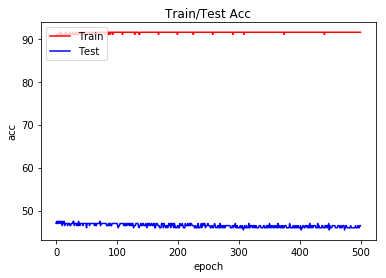

In [174]:
#plot train/val accuracies
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
line1 = plt.plot(train_acc, color='red')
line2 = plt.plot(val_acc, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlp2.png')   # save the figure to file
plt.show()
plt.close()